# CLDIFF

好家伙，原来是 Concise Linked Code Difference 的简称，我第一次以为是 Class Difference（

文中说主要的问题是：Code diff 工具的粒度太细，但 Code change summary 工具的粒度太粗。生成便于人类理解的 Code diff 和 change summary 是这个 CLDIFF 解决的问题。 

CLDIFF 的输入是源文件。其会在预处理阶段根据 AST 删除未修改的定义；第二步生成语句级 (statement level) 及以上的分析，来解决上述问题；第三步是把 code difference 联系起来。这里出现了一个 five pre-defined links，看起来应该是后文的一个重点。

## 1. Introduction

其实想想就能明白，单纯基于文本的差异分析肯定不太行，因为它缺乏一个通用的表达方式：不同算法所使用的处理方法、输出结果都太不同了。而且算法或许没有什么扩展性吧。反观在 AST 上看就很好，我被说服了。

对于刚提交的一个 commit，我去看文本上的 diff 肯定没问题。关键是过了一段时间，我就看 git diff 出来的那点玩意儿确实是不知道自己在干什么。哪怕结合着 commit message 看（commit messgae 大概率也是当时 commit 的时候太过于兴奋无法组织语言而写出来的谜语），瞬间看懂的可能性也很小。这其实就是 code 与人类之间的距离。

（比较两个 AST 的结构，不知道为什么我想到了那道经典的 “编辑距离”。）

改变一个地方，带来的影响不是 git diff 中简简单单两三行 “+++ ---” 可以搞定的。改变一个方法的名字，可能会让某个源文件调用的方法被修改。文本上的 diff 并不能说明全部情况，甚至不能说明部分情况。

（**注：看完文章之后发现这里说得很有问题，其实和改变方法名字没什么关联。是我读到这里的时候大脑联想出了问题。**）

反观 code summary 就是另外一个极端。通过对 commit message / release note 的文字处理，优化有关 code change 的 documentation。

那么读到这里我就明白 CLDIFF 打算做什么了。

一个程序有没有得到改动，这个 “改动” 的概念很难得说。

但毫无疑问，AST 如果没改，程序代码的执行在期望输入输出的对应上肯定是没有变化的，而且还可以避免一些因素的影响，比如注释。

CLDIFF 通过 “grouping code differences” 这个过程，把比较分散、但是却又与一些模式（文中称之为 high-level AST element）匹配的代码变更提炼出来。

## 2. Preliminary

我擦，真的。

AST 的差异可以转化为 edit script，也就是 git diff 里面那一堆 “+++ ---”。并且比较两个 AST 间由于编辑导致的差异的方法，还真的就是有建立 “从 old 到 new” 的 Map 这么一个方法？

文中的 fig 2.c / 2.d 说明了这一点：

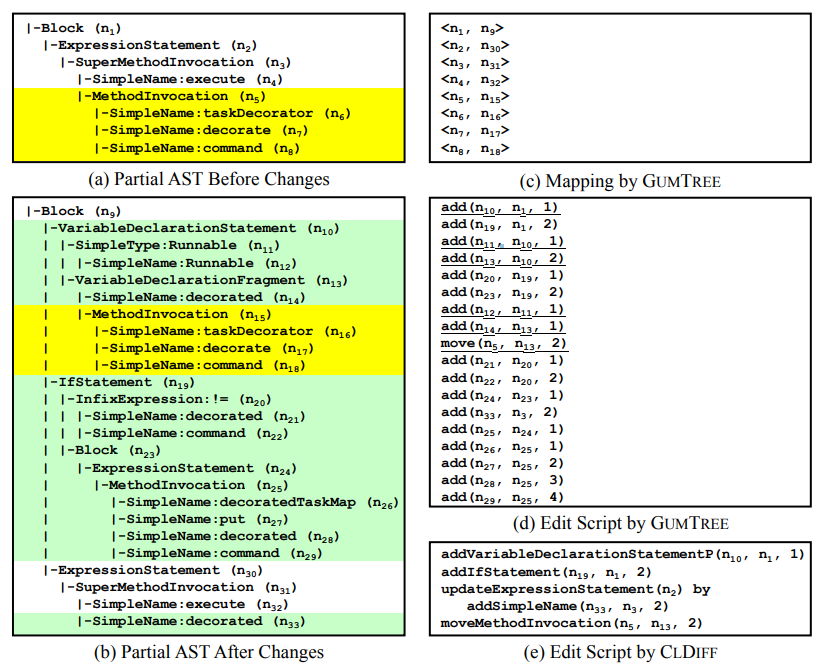

为了未来可能还要再看一遍这篇论文的我，这里注释一下，对于 2.d

* add 指的是在 input2 的位置插入 input1，并且插入的这个节点作为插入后树那一层的第 input3 个子节点。
* move 指的是把 old 中的 input1 移动到 new 中的 input2 下，并且作为移动过后的 input2 下的第 input3 个子节点。

总之，看上去这个 GumTree 就是完全的编辑距离。而且是 **具体到了最基本 element** 的编辑距离。摘要中说了，CLDIFF 就是要在 statement level 及以上给出 edit script。所以对于 2.a 到 2.b 的修改，CLDIFF 会尽可能地归纳（也就是从树叶节点向根节点方向回溯）。

## 3. Motivation & Overview

看起来就像是把 git 里面用来判断文件 add / delete / move 的算法从文件树挪到了 AST 一般。这里详细叙述一下那三步：

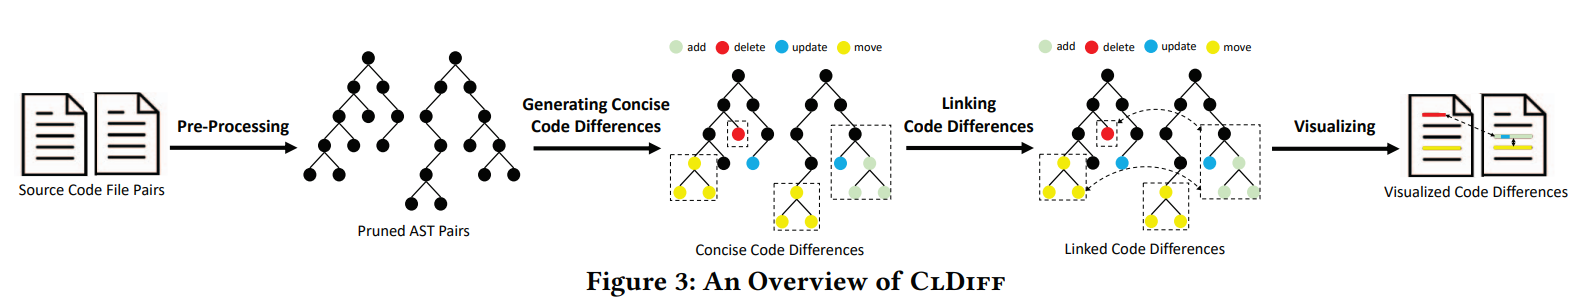

### i. 预处理

首先要删除一些没有修改的地方（两个文本相同之处），在本文中，变更分析不分析不变的。所以只需要把两棵 AST 不重合的地方拿出来。

此外，还要删除不变的 declaration-level element。还是那个问题，这些东西太细了，人类确实理解起来有点困难。

### ii. 变更统合

细粒度的变更就如 2.d 中那样，究其原因是算法太想用 “过分 basic 的操作” 以及 “过于少的操作种类” 来描述代码变更。

CLDIFF 并没有从 AST 到变更种类统合从头到尾自己写完，而是借用了 GumTree 的输出 map。然后再使用这个 map 来做树上的算法。

对于 GumTree 的输出，我这里有一种说法就是：“它对树形结构的利用过于有限了”。这个原因是 **它过分考虑设计模式，把树中的每一个节点都当成同层次 object 考虑**。当然我不是说 “组件模式不是描述树的一种有效方式”，而且我觉得无论如何，AST 相关的 lib 都会考虑使用组件模式描述一棵树 / 或是树的一部分。

但是代码实现和考虑问题的方法可以脱开。代码虽然都是 extends 了某一个 base class，但是从想法上，我们可以不考虑其 inherit 这个维度，可以考虑下给不同的树节点分类。比如 statement 肯定是 AST 的节点，但是如果用描述 variabledeclaration 的方法描述它，总归是 **为了代码上的精炼和设计模式上的优美，去选择丢弃了 AST 在设计时考虑到的层次性**。

话说回来，CLDIFF 会生成一个 concise code difference。

### iii. 链接差异

代码变更经常会影响其他部分，所以 CLDIFF 最后还会在 new 和 old 两份代码间建立联系。